Se importan las librerias necesarias

In [222]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import re
import nltk
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.feature_selection import SelectKBest, chi2

La libreria de los tokens a utilizar puede ser instalada con el comando pip install --user -U nltk .

Para la carga de los datos se efectua el siguiente metodo.

In [223]:
data=pd.read_csv('kindle_reviews.csv', sep=',', encoding = 'utf-8')

Preprocesamiento de los datos

Se consideran de utilidad unicamente las columnas que tienen el ID del producto, la calificacion y el comentario para predecir los sentimientos que generan este. Mas adelante, tendremos en cuenta solo los casos extremos, calificaciones de 1 y 5 para tener una mayor exactitud del modelo.

In [224]:
filteredData = data.loc[:, ["asin", "reviewText", "overall",]]

Se examina la distribucion de los datos segun las calificaciones de los comentarios

In [225]:
overallDistribution = filteredData.overall.value_counts().sort_index()
print(overallDistribution)

1     23018
2     34130
3     96194
4    254013
5    575264
Name: overall, dtype: int64



Lo más importante es que el número de comentarios positivos son significantemente mayores que las neutrales y als negativas. Esta situacion nos encamina a un dataset que debe ser corregido antes de entrenar los datos.

Se toman los datos  de 1 estrella y 5 estrellas como casos positivos y negativos respectivamente. Escogiendo los casos extremos, hará el modelo mucho más preciso.

In [226]:
#Performs the Data Bining of Overall field Phase for the Binary
# classification problem 1
#Input:
#[data]: Dataframe list of n datasets
#[overallSegmentSize]: Size of each overall field possible value
#Output [cleanedData]: Dataframe list of n datasets

def overallBining1and5(data, overallSegmentSize):
    #Select and limit Ngeative Reviews
    negReviews1 = data[data.overall == 1]
    negReviews = negReviews1.iloc[:overallSegmentSize ,:]
    #Select and limit Positives Reviews    
    posReviews5 = data[data.overall == 5]
    posReviews = posReviews5.iloc[:overallSegmentSize, :]
    
    cleanedData = pd.concat([negReviews, posReviews])
    #Reset indexes to iterate cleanedData Dataframe
    cleanedData = cleanedData.reset_index(drop=True)
    
    #Data bining assignation
    cleanedData['overall'] = cleanedData['overall'] == 5
    return cleanedData

Se hace la liempieza de los datos con la clasificacion binaria descrita anteriormente

Se busca el tamaño de segmento adecuado para generar una distribución rectangular de los datos limitando el tamaño de cada una de las etiquetas, por ende, decrece notablemente el tamaño de nuestro dataset, pero lo vuelve uno más preciso y adecuado para trabajar.

In [227]:
overallSegmentSize = overallDistribution.min(axis = 0)

Para esto se usa el método de clasificación binaria creado anteriormente.

In [228]:
cleanedData= overallBining1and5(filteredData,overallSegmentSize)

Verificamos la nueva distribucion

In [229]:
overallDistribution = cleanedData.overall.value_counts().sort_index()
print(overallDistribution)

False    23018
True     23018
Name: overall, dtype: int64


Transformaciones NP


In [230]:
"""NLP TRANSFORMATIONS"""
def getGlobalNLTKVars():
    #Global NLTK Variables
    ret = RegexpTokenizer('[a-zA-Z0-9\']+')
    sw = set(stopwords.words('english'))
    #lemmaTokenizer
    wnl = WordNetLemmatizer()
    #stemTokenizer
    ess = SnowballStemmer('english')
    #POSTokenizer
    allowed_word_types = ["ADJ", "ADV", "NOUN", "VERB"]
    return ret, sw, wnl, ess, allowed_word_types



In [231]:
from nltk.corpus import stopwords

In [232]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [233]:
#Global NLTK Variables
ret, sw, wnl, ess, allowed_word_types = getGlobalNLTKVars()

Considerando la bolsa de palabras del dataset de comentarios. Hay caso como "protagonista" y "protagonistas" o "incrementa", "incrementan" e "incrementando". En el primer caso, el plural de un sustantivo no agrega informacion de calida y puede ser tomada como la singular como una representacion unica ("Protagonista"). En el segundo caso, hay demasiadas posibilidades con la conjugacion del verbo y considerarla a cada una de estas no es representativo.

El tokenizer stem mantiene la raiz de cada palabra

In [234]:
#Stemmer Tokenizer
def stemTokenizer(sentence):
    tokens= ret.tokenize(sentence)
    #return [ess.stem(t) for t in tokens if t not in sw]
    return [ess.stem(t) for t in tokens]


Nos ayuda a hacer una clasificacion de las palabras gracias a la lemmatizacion

In [235]:
#return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v)
def get_wordnet_pos(pos):
    pos_wn = [] 
    for i in range(0, len(pos)):
        if pos[i][1] == 'ADJ':
            pos_wn.append(wn.ADJ)
        elif pos[i][1] == 'VERB':
            pos_wn.append(wn.VERB)
        elif pos[i][1] == 'ADV':
            pos_wn.append(wn.ADV)
        else:
            # As default pos in lemmatization is Noun
            pos_wn.append(wn.NOUN)
    return pos_wn

El Tokenizer POS esta encargado de seleccionar un rango especifico de tipos de palabras. Asi nos deshacemos de las palabras que no influyen en los sentimientos del comentario como articulos,determinantes y modales.

In [236]:
#Part of Speech Tokenizer
def POSTokenizer(sentence):
    tokens= ret.tokenize(sentence)
    pos = nltk.pos_tag(tokens, tagset = "universal")
    return [wnl.lemmatize(pos[i][0] ) for i in range(0, len(tokens)) 
            if pos[i][1] in allowed_word_types]

 Lemma almacena una palabra de verdad y su POS tag.

In [237]:
#Lemmatization Tokenizer
def lemmaTokenizer(sentence):
    tokens= ret.tokenize(sentence)
    pos = nltk.pos_tag(tokens, tagset = "universal")
    pos_wn = get_wordnet_pos(pos)
    return [wnl.lemmatize(pos[i][0], pos_wn[i]) for i in range(0, len(tokens))]

Se tienen en cuenta varios modelos de regresión logística a probar

En este caso, se escogieron los modelos mas precisos, la regresion logistica, MNB y SVM ya que arrojaban unos excelentes resultados como se podra ver mas adelante en la evaluacion del modelo.

In [238]:
 #Building of a Pipeline
def buildPipeline(pipelineId):
    if  pipelineId == 1:
        #Pipeline 1
        text_clf = Pipeline([('vect', TfidfVectorizer(tokenizer = stemTokenizer,
                                    ngram_range=(1, 2), 
                                    binary = True, min_df=2, max_df=0.8)),
                     ('chi2', SelectKBest(chi2, k=5000)),
                     ('clf', LogisticRegression())])
    elif pipelineId == 2:
        #Pipeline 2 MultinomialNB
        
        text_clf = Pipeline([
                            ('vect', CountVectorizer(
                                                     max_features = 5000)),
                          ('clf', MultinomialNB()),])
    elif pipelineId == 3:
        #Pipeline 3 SGD
        text_clf = Pipeline([('vect', CountVectorizer(
                                                     max_features = 5000)),
                          ('clf', SGDClassifier()),])
     
    return text_clf

Para entrenar el modelo

Se crean metodos para visualizar las predicciones hechas por los modelos.

In [239]:
# Take a look at the words in the vocabulary
def printBoW(vect, X_train):
    # fit and transform X_train into X_train_dtm
    X_train_dtm = vect.fit_transform(X_train)
    X_train_dtm = X_train_dtm.toarray()
    vocab = vect.get_feature_names()
    #print(vocab)
    #•print the counts of each word in the vocabulary
    # Sum up the counts of each vocabulary word
    freq = np.sum(X_train_dtm, axis=0)
    # For each, print the vocabulary word and the number of times it 
    # appears in the training set
    freqList = list(freq)
    bowDict = {'vocab': vocab, 'freq': freqList}
    bowDf = pd.DataFrame(data=bowDict)
    df_sortedByValue = bowDf.sort_values("freq", ascending=0)
    #print(df_sortedByValue.head(50))
    #plotBoW(df_sortedByValue)
    return df_sortedByValue

Tambien se crea una funcion para visualizar correctamente la matriz de confusion

In [240]:
def printConfusionMatrix(y_test, y_pred_class):
    print("Confusion matrix\n", metrics.confusion_matrix(y_test, y_pred_class))

Para el reporte de los datos

In [241]:
def printClfReport(y_test, y_pred_class):
    print("Classification Report\n",metrics.classification_report(y_test, y_pred_class))

Para la curva ROC

In [242]:
def plotROCCurve(y_test, y_pred_class):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred_class)

    #Print ROC Curve
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")   
    plt.show()

Para las palabras mas repetidas

In [243]:
def plotBoW(df_sortedByValue, kMostFrequentWords):
    df_sortedByValue = df_sortedByValue.reset_index(drop=True)
    df_sortedByValue = df_sortedByValue.head(kMostFrequentWords)
    vocab = df_sortedByValue.loc[:, 'vocab']
    freq = df_sortedByValue.loc[:, 'freq']
    
    #Matplotlib order String arrays in alphabetical order by default
    #In order to respect the original order:
    #Use values 0,1,2,3,4,... as x and assign vocab with tick_label=
    plt.bar(range(len(vocab)), freq , tick_label=vocab)
    
    plt.xticks(rotation = 45)
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title('%d Most frequent words' % kMostFrequentWords , fontweight='bold')
    
    plt.show()

Para visualizar los primeros falsos positivos y falsos negativos en el modelo para cersiorarnos de la validez del modelo mas adelante

In [244]:
def getFPandFN(X_test, y_test, y_pred_class):
    # first 10 false positives
    #(Negative reviews incorrectly classified as Positive reviews)
    FP = X_test[y_test < y_pred_class]
    # first 10 false negatives
    #(Positives reviews incorrectly classified as Negatives reviews)
    FN = X_test[y_test > y_pred_class]
    print("False Positive Reviews: \n")
    for i in range(0, 3):
        print(FP.iloc[i])
        print("\n\n")
    print("False Negative Reviews: \n")
    for i in range(0, 3):
        print(FN.iloc[i])
        print("\n\n")
    return FP, FN

Se escoge la variable X y la variable y para nuestro modelo. 

In [245]:
X = cleanedData.reviewText
y = cleanedData.overall 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, 
                                                        random_state=1)
parameters = {'vect__tokenizer': (lemmaTokenizer, None)}

REGRESION LOGISTICA

Se crea la pipleine para el modelo de regresión logística

In [246]:
pipelineId = 1
text_clf = buildPipeline(pipelineId)
    
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(X_train, y_train)

C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\nicol\

Se obtiene el mejor resultado

In [247]:
print("Best score:  %.2f%%" % float(100*gs_clf.best_score_))

Best score:  94.29%


Se hace la transformacion con CountVectorizer dentro de la pipeline

In [248]:
#The pipeline already does the transformation using CountVectorizer
X_test = X_test.reset_index(drop=True)
X_test = X_test[:300]
y_test = y_test.reset_index(drop=True)
y_test = y_test[:300]
y_pred = gs_clf.best_estimator_.predict(X_test)
y_pred = pd.Series(data = y_pred)

Se guarda el vector de estimación de los pasos

In [249]:
vect = gs_clf.estimator.steps[0][1]

Reporte de clasificacion

In [250]:
printClfReport(y_test, y_pred)

Classification Report
               precision    recall  f1-score   support

       False       0.95      0.99      0.97       150
        True       0.99      0.95      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



Matriz de confusion

In [251]:
printConfusionMatrix(y_test, y_pred)

Confusion matrix
 [[148   2]
 [  7 143]]


Curva ROC

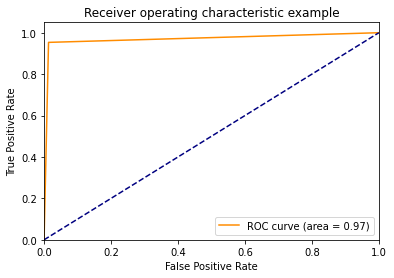

In [252]:
plotROCCurve(y_test,y_pred)

SUPPORT VECTOR MACHINE (SGD CLASSIFIER)

In [253]:
pipelineId = 3
text_clf = buildPipeline(pipelineId)
    
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(X_train, y_train)

C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\nicol\

In [254]:
print("Best score:  %.2f%%" % float(100*gs_clf.best_score_))

Best score:  93.17%


In [255]:
#The pipeline already does the transformation using CountVectorizer
X_test = X_test.reset_index(drop=True)
X_test = X_test[:300]
y_test = y_test.reset_index(drop=True)
y_test = y_test[:300]
y_pred = gs_clf.best_estimator_.predict(X_test)
y_pred = pd.Series(data = y_pred)

In [256]:
vect = gs_clf.estimator.steps[0][1]

In [257]:
printClfReport(y_test, y_pred)

Classification Report
               precision    recall  f1-score   support

       False       0.97      0.97      0.97       150
        True       0.97      0.97      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [258]:
printConfusionMatrix(y_test, y_pred)

Confusion matrix
 [[146   4]
 [  5 145]]


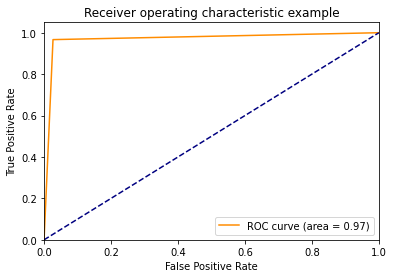

In [259]:
plotROCCurve(y_test,y_pred)

Se verifican los primeros 3 falsos positivos y falsos negativos para verificar la validez del modelo

In [260]:
getFPandFN(X_test,y_test,y_pred)

False Positive Reviews: 

I really like Alexa and think she's amazing but I don't agree with how her relationship's with David and Rachel ended. I feel like David got of easy for his infidelity. He tells his wife, then brings his kid home and thinks Alexa will just have to give in. He gets to keep his marriage and son and move on as if nothing happened. His practice doesn't even suffer. I feel like Alexa and Rachel suffer but David gets away with what he does.  Rachel sufferers when she gets locked up as she loses her family. She also loses the opportunity to connect with her son. Even though she suffers, I feel like she should have apologized to Alexa. Although some would see her giving up custody of her son as her way to right her wrong. I don't know that anyone can actually be as forgiving as Alexa was. I feel like she gets the short end of the stick and has to make due. I wanted a better ending for her. The story is well written and makes you want to know what will happen next.





(7      I really like Alexa and think she's amazing bu...
 30     I'm pretty sure that in this book (like the fi...
 31     I did not read this book because it gave you j...
 240    Don't start reading this book if you expect it...
 Name: reviewText, dtype: object,
 38     Lots of soft romance and action in densely pac...
 39     Like both characters.  Sara was irritating at ...
 53     Just finished this one.  I gave all the Spinwa...
 183    Okay I like sharia writing, I don't care about...
 195    There are plenty of ideas in this imaginative ...
 Name: reviewText, dtype: object)

Para el algoritmo MULTINOMIAL NATIVE BAYES (MNB)

In [261]:
pipelineId = 2
text_clf = buildPipeline(pipelineId)
    
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)
gs_clf = gs_clf.fit(X_train, y_train)

C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\nicol\

In [262]:
print("Best score:  %.2f%%" % float(100*gs_clf.best_score_))

Best score:  91.90%


In [263]:
#The pipeline already does the transformation using CountVectorizer
X_test = X_test.reset_index(drop=True)
X_test = X_test[:300]
y_test = y_test.reset_index(drop=True)
y_test = y_test[:300]
y_pred = gs_clf.best_estimator_.predict(X_test)
y_pred = pd.Series(data = y_pred)

In [264]:
vect = gs_clf.estimator.steps[0][1]

In [265]:
printClfReport(y_test, y_pred)

Classification Report
               precision    recall  f1-score   support

       False       0.91      0.97      0.94       150
        True       0.97      0.90      0.93       150

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



In [266]:
printConfusionMatrix(y_test, y_pred)

Confusion matrix
 [[146   4]
 [ 15 135]]


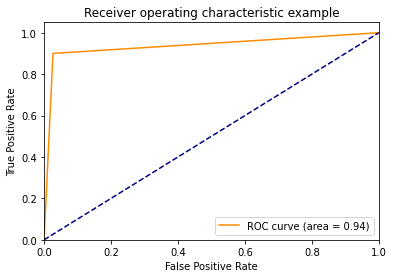

In [267]:
plotROCCurve(y_test,y_pred)

Se observan los primeros 3 falso positivos y 3 falsos negativos para verificar que la prediccion sea correcta

In [268]:
getFPandFN(X_test,y_test,y_pred)

False Positive Reviews: 

I really like Alexa and think she's amazing but I don't agree with how her relationship's with David and Rachel ended. I feel like David got of easy for his infidelity. He tells his wife, then brings his kid home and thinks Alexa will just have to give in. He gets to keep his marriage and son and move on as if nothing happened. His practice doesn't even suffer. I feel like Alexa and Rachel suffer but David gets away with what he does.  Rachel sufferers when she gets locked up as she loses her family. She also loses the opportunity to connect with her son. Even though she suffers, I feel like she should have apologized to Alexa. Although some would see her giving up custody of her son as her way to right her wrong. I don't know that anyone can actually be as forgiving as Alexa was. I feel like she gets the short end of the stick and has to make due. I wanted a better ending for her. The story is well written and makes you want to know what will happen next.





(7      I really like Alexa and think she's amazing bu...
 62     Even if you're ready to buy that a beautiful (...
 150    I love the Texas Rangers, they are one of my f...
 156    This book is anal, and I mean in every physica...
 Name: reviewText, dtype: object,
 35     I really liked the book.  I was referred to th...
 38     Lots of soft romance and action in densely pac...
 39     Like both characters.  Sara was irritating at ...
 53     Just finished this one.  I gave all the Spinwa...
 92     five good ald science fiction tales from the 4...
 97     A book that makes you think while you're readi...
 111    I know it is listed as a short story but I rea...
 126    This book is an Excellent Story about staying ...
 160    There is an elegance to the language used in t...
 162    Holy biscuits! This was just waaay too wild.  ...
 183    Okay I like sharia writing, I don't care about...
 195    There are plenty of ideas in this imaginative ...
 257    First of all, I downloaded thi